# Get Start

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.0.1+cu117
torchvision version: 0.15.2+cu117


data를 다운받을 수 있는 script를 github에서 clone 해서 사용 

In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except: 
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

# Get Data 

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

pizza , sushi , steak 등 음식 이미지 다운

In [4]:
from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")

image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test" 

# Create Datasets and DataLoaders 

ViT 논문의 Table3를 보면 훈련 데이터의 해상도는 224로 설정되어 있습니다. 또한 배치 사이즈가 4096으로 나와있으나 실제 실습에서는 더 작은 사이즈로 진행합니다.

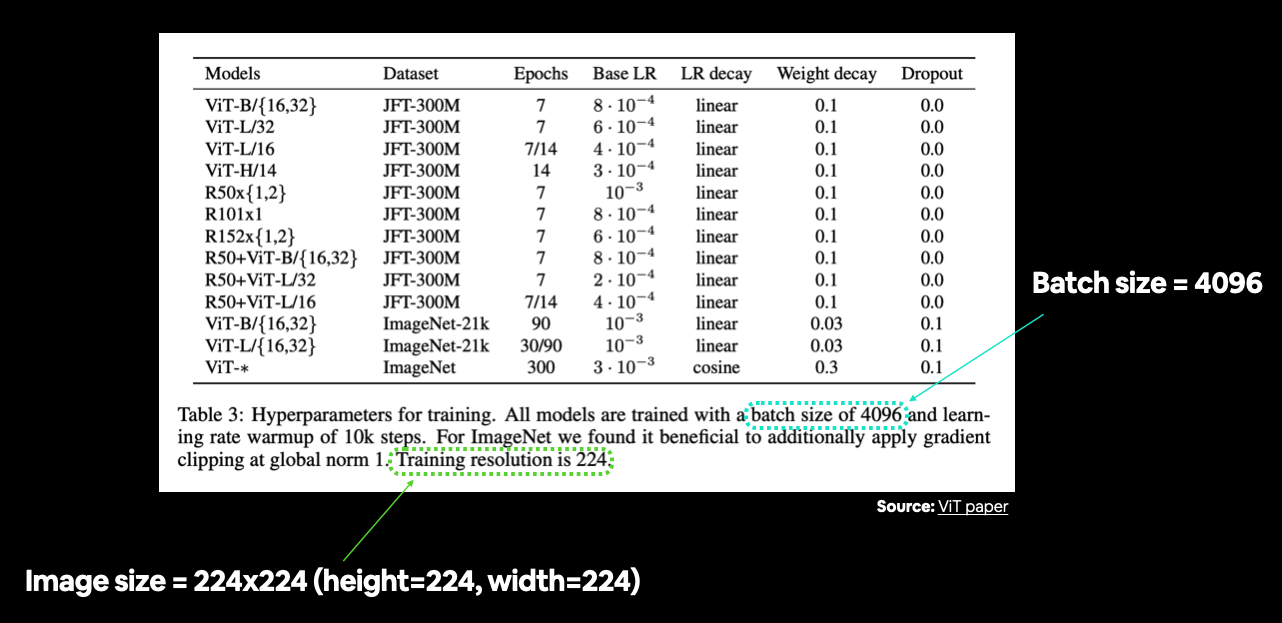

Transforms for images 준비

In [6]:
IMG_SIZE = 224 

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"Preparing data loaders...{manual_transforms}")

Preparing data loaders...Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


### Turn images into DataLoader's 

배치 사이즈 4096은 모델이 가중치를 한 번 업데이트하기 전에 4096개의 샘플을 처리한다는 의미입니다. 

이는 한 번의 전방 패스(forward pass)와 역방향 패스(backward pass)에서 4096개의 샘플이 사용된다는 뜻입니다.

In [7]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)
  class_names = train_data.classes
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [8]:
BATCH_SIZE = 32

train_dataloader , test_dataloader, class_names = create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,    
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fd0d5789160>,
 ['pizza', 'steak', 'sushi'])

## Visualize a single image

In [11]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(-0.5, 223.5, 223.5, -0.5)

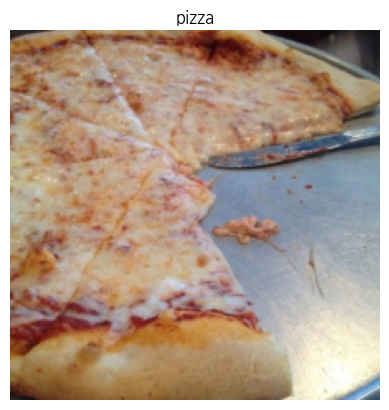

In [12]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("off")

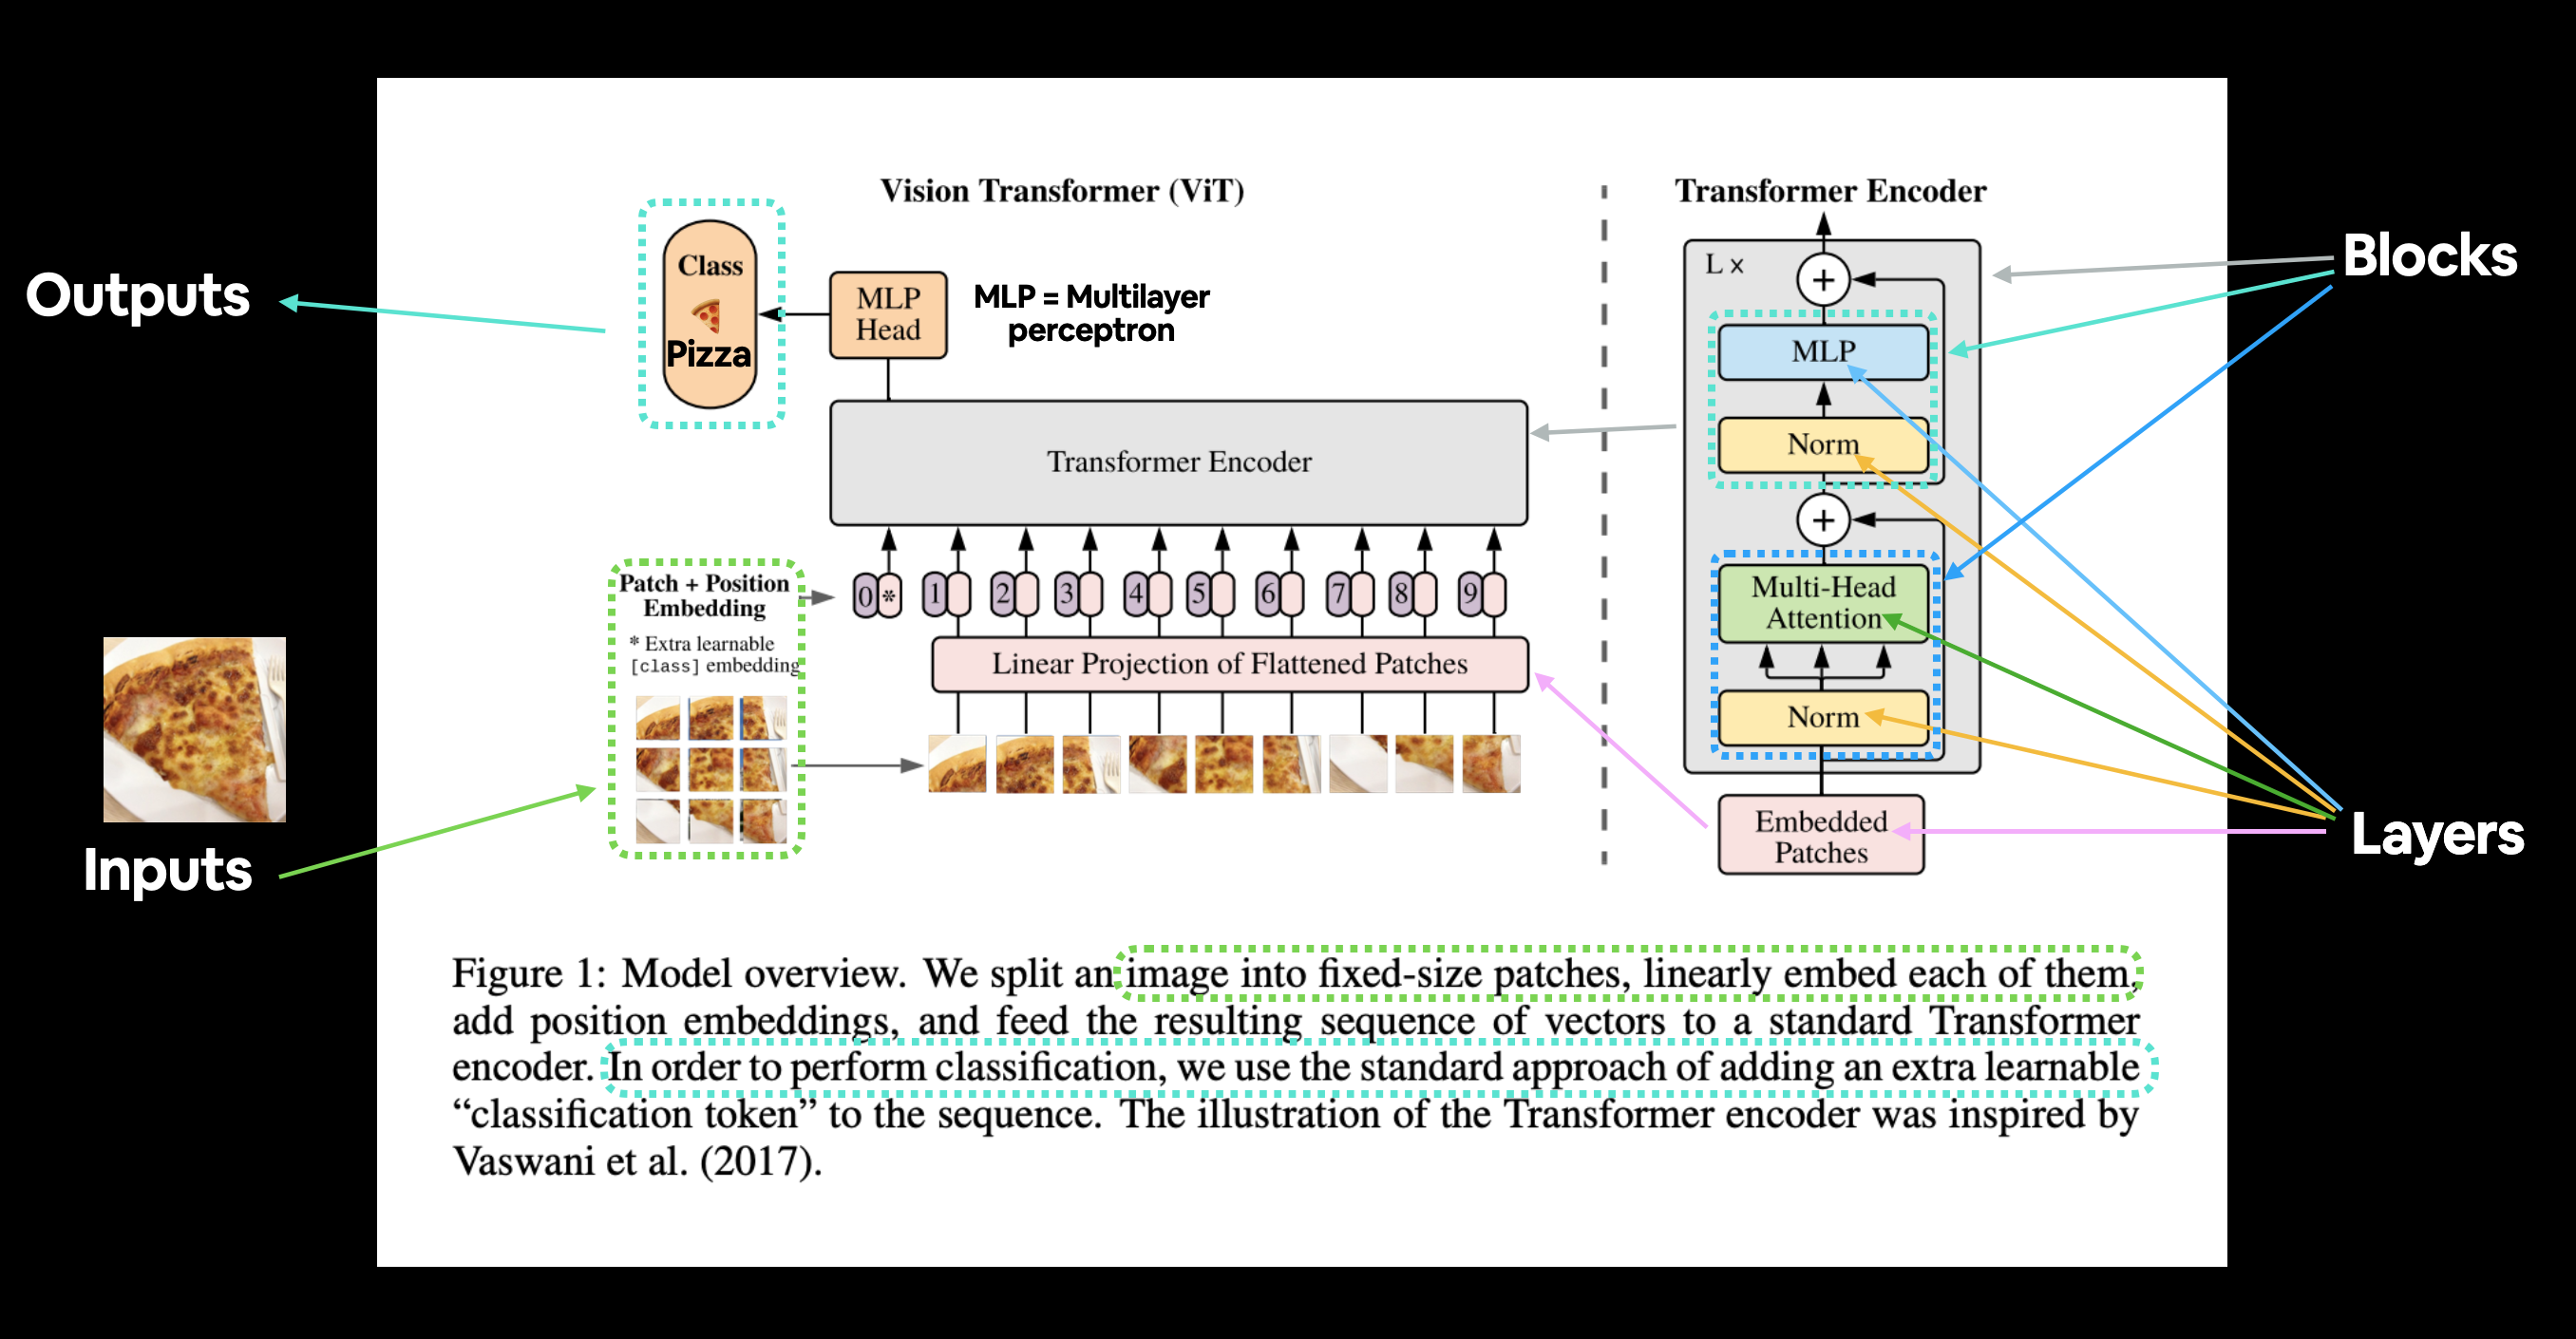

TransformerEncoderBlock() 클래스 대신 `torch.nn.TransformerEncoderLayer()`로 대체해봅시다. 

우리는 `torch.nn.TransformerEncoderLayer()`를 쌓아서 Encoder 부분을 구현할 수 있습니다. 

필요한 부분들을 나열해보면 

1. PatchEmbediing
2. Transformer Encoder layer 
3. Stack multiple transformer encoder layers on top of each other 
4. MLP head 
5. Put it all together to create ViT

# Make Patch Embedding Layer

In [13]:
class PatchEmbedding(nn.Module): 

    def __init__(self, in_channels : int = 3 , patch_size : int =16, embedding_dim:int =768):
        super().__init__()

        self.patcher = nn.Conv2d(
            in_channels = in_channels,
            out_channels = embedding_dim,
            kernel_size=patch_size, 
            stride=patch_size,
            padding=0)
        
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)    

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0 , f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"  

        x_patched = self.patcher(x) 
        x_flatten = self.flatten(x_patched)

        return x_flattened.permute(0, 2, 1)